# Holiday Modeling Using Google Trends Data

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib

import cmdstanpy
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.30.1
Install directory: /Users/daniel.marthaler/.cmdstan
CmdStan version 2.30.1 already installed


True

In [3]:
from cmdstanpy import CmdStanModel

In [4]:
from bayesian_holidays.src.holiday_model import fit_holiday_model

In [5]:
from bayesian_holidays.src.utils import (
    create_d_peak,
    create_mask_logistic,
    fourier_design_matrix,
    get_holiday_dataframe,
    create_stan_data
)

In [6]:
from pytrends.request import TrendReq

In [7]:
ptrends = TrendReq()

In [8]:
start_date_str = "2015-11-08"
end_date_str = "2022-11-08"

In [9]:
start_date = None
end_date = None

In [10]:
ptrends.build_payload(["chocolate"], timeframe=start_date_str + ' ' + end_date_str)

In [12]:
df = ptrends.interest_over_time().drop(columns=['isPartial']).reset_index().rename(columns={'chocolate':'observed'})

In [13]:
# df_xmas, fit_xmas = fit_holiday_model(
#     df,
#     start_date=start_date,
#     train_split=80,
#     num_chains=2,
#     max_treedepth=10,
#     adapt_delta=0.8
# )


In [36]:
train_split=80;
num_chains=2;
max_treedepth=10;
adapt_delta=0.8;

In [15]:
df["observed"] = df["observed"].replace(["<1"], "0").astype(int)
if start_date is None:
    start_date = df["date"].min()
else:
    assert pd.to_datetime(start_date) >= df["date"].min()
    start_date = pd.to_datetime(start_date)
df = df[df["date"] >= pd.to_datetime(start_date)]
end_date = df["date"].max()

In [16]:
holiday_years = list(
    range(pd.to_datetime(start_date).year - 1, pd.to_datetime(end_date).year + 1)
)
holiday_list = (
    get_holiday_dataframe(years=holiday_years)
    .sort_values(by="HolidayDate")
    .reset_index()
)

train_date = df.date.iloc[int((train_split / 100) * df.date.shape[0])]

df_train = df[df.date <= train_date]
df_test = df[df.date > train_date]

d_peak = create_d_peak(df_train.date, holiday_list)
d_peak_test = create_d_peak(df_test.date, holiday_list)

hol_mask = create_mask_logistic(df_train.date, holiday_list)
hol_mask_test = create_mask_logistic(df_test.date, holiday_list)

num_modes_year = 3
T_PER_YEAR = 52.1429

X_year = fourier_design_matrix(
    np.array(df_train.date.dt.isocalendar().week.values, dtype=int),
    period=T_PER_YEAR,
    num_modes=num_modes_year,
)

X_year_test = fourier_design_matrix(
    np.array(df_test.date.dt.isocalendar().week.values, dtype=int),
    period=T_PER_YEAR,
    num_modes=num_modes_year,
)

In [17]:
stan_data = create_stan_data(
    df_train.observed,
    num_modes_year,
    X_year,
    X_year_test,
    d_peak,
    d_peak_test,
    hol_mask,
    hol_mask_test,
)

In [76]:
holiday_model = CmdStanModel(
    stan_file="/Users/daniel.marthaler/dev/bayesian_holidays/bayesian_holidays/src/new_holiday_model.stan",
    cpp_options={"CXX": "arch -arch arm64e clang++"},
)

11:14:45 - cmdstanpy - INFO - compiling stan file /Users/daniel.marthaler/dev/bayesian_holidays/bayesian_holidays/src/new_holiday_model.stan to exe file /Users/daniel.marthaler/dev/bayesian_holidays/bayesian_holidays/src/new_holiday_model
11:14:56 - cmdstanpy - INFO - compiled model executable: /Users/daniel.marthaler/dev/bayesian_holidays/bayesian_holidays/src/new_holiday_model


In [77]:
holiday_fit = holiday_model.sample(
        chains=num_chains,
        iter_warmup=250,
        iter_sampling=250,
        data=stan_data,
        max_treedepth=max_treedepth,
        adapt_delta=adapt_delta,
        show_progress=True,
        output_dir="./data",
    )

11:14:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

11:15:20 - cmdstanpy - INFO - CmdStan done processing.
11:15:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: new_holiday_model_model_namespace::log_prob: lambda_tilde_m[1] is nan, but must be greater than or equal to 0.000000 (in '/Users/daniel.marthaler/dev/bayesian_holidays/bayesian_holidays/src/new_holiday_model.stan', line 137, column 2 to line 139, column 4)
	Exception: poisson_log_rng: Log rate parameter is nan, but must be finite! (in '/Users/daniel.marthaler/dev/bayesian_holidays/bayesian_holidays/src/new_holiday_model.stan', line 227, column 4 to column 55)
	Exception: poisson_log_rng: Log rate parameter is nan, but must be finite! (in '/Users/daniel.marthaler/dev/bayesian_holidays/bayesian_holidays/src/new_holiday_model.stan', line 227, column 4 to column 55)
	Exception: poisson_log_rng: Log rate parameter is nan, but must be finite! (in '/Users/daniel.marthaler/dev/bayesian_holidays/bayesian_holidays/src/new_holiday_model.stan', line 227, column 4 to c

11:15:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 12 divergent transitions (4.8%)
	Chain 2 had 4 divergent transitions (1.6%)
	Use function "diagnose()" to see further information.


In [78]:
print(holiday_fit.diagnose())

Processing csv files: /Users/daniel.marthaler/dev/bayesian_holidays/notebooks/data/new_holiday_model-20221115111457_1.csv, /Users/daniel.marthaler/dev/bayesian_holidays/notebooks/data/new_holiday_model-20221115111457_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
16 of 500 (3.20%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  lambda_tilde[1], lambda_tilde[12], h_scale_raw[1], h_scale_raw[12], lambda_m_unif[1], lambda_m_unif[12], holiday_effect[1], holiday_effect[13], holiday_effect[25], holiday_effect[37], holiday_

In [79]:
from bayesian_holidays.src.plot_utils import plot_posteriors

In [80]:
#plot_posteriors(df,holiday_fit,"chocolate")
df_fit = holiday_fit

In [81]:
plot_train=True; plot_test=True;
alpha = df_fit.stan_variable("alpha")
seasonality = df_fit.stan_variable("seasonality")
holiday_effect = df_fit.stan_variable("holiday_effect")
log_mu = alpha.reshape(-1,1) + seasonality + holiday_effect
# log_mu = df_fit.stan_variable('obs_mean');

In [82]:
from scipy.special import logit, expit

def get_holiday_lift(h_skew, h_shape, h_scale, h_loc, intensity, d_peak, hol_mask):
    num_holidays, num_dates = d_peak.shape
    tdd = np.zeros((h_loc.shape[0], h_loc.shape[1], d_peak[0, :].shape[0]))
    
    z = (np.expand_dims(d_peak_test,axis=0) - np.expand_dims(h_loc,axis=2)) / np.expand_dims(h_scale,axis=2)
    tdd = np.sum(
        2.0 * np.expand_dims(intensity,axis=2)
        * np.exp(-np.abs(z) ** np.expand_dims(h_shape,axis=2))
        * expit(np.expand_dims(h_skew,axis=2) * z)
        * np.expand_dims(hol_mask,axis=0)
    , axis=1)
    return tdd

In [83]:
h_skew = df_fit.stan_variable("h_skew")
h_shape = df_fit.stan_variable("h_shape")
h_scale = df_fit.stan_variable("h_scale")
h_loc = df_fit.stan_variable("h_loc")
intensity = df_fit.stan_variable("intensity")

In [84]:
th = get_holiday_lift(h_skew, h_shape, h_scale, h_loc, intensity, d_peak_test, hol_mask_test)

In [85]:
#test_seasonality = np.dot(df_fit.stan_variable('fourier_coefficients'), stan_data['X_year_test'])
#test_holiday_effect = get_holiday_lift(h_skew, h_shape, h_scale, h_loc, intensity, d_peak_test, hol_mask_test)
test_seasonality = df_fit.stan_variable('test_seasonality')
test_holiday_effect = df_fit.stan_variable('test_holiday_effect')
test_log_mu = alpha.reshape(-1,1) + test_seasonality + test_holiday_effect
# test_log_mu = df_fit.stan_variable('test_obsmean')

train_date = df.date.iloc[int(0.8 * df.shape[0])]

df_train = df[df.date <= train_date]
df_test = df[df.date > train_date]

In [86]:
name = "chocolate"

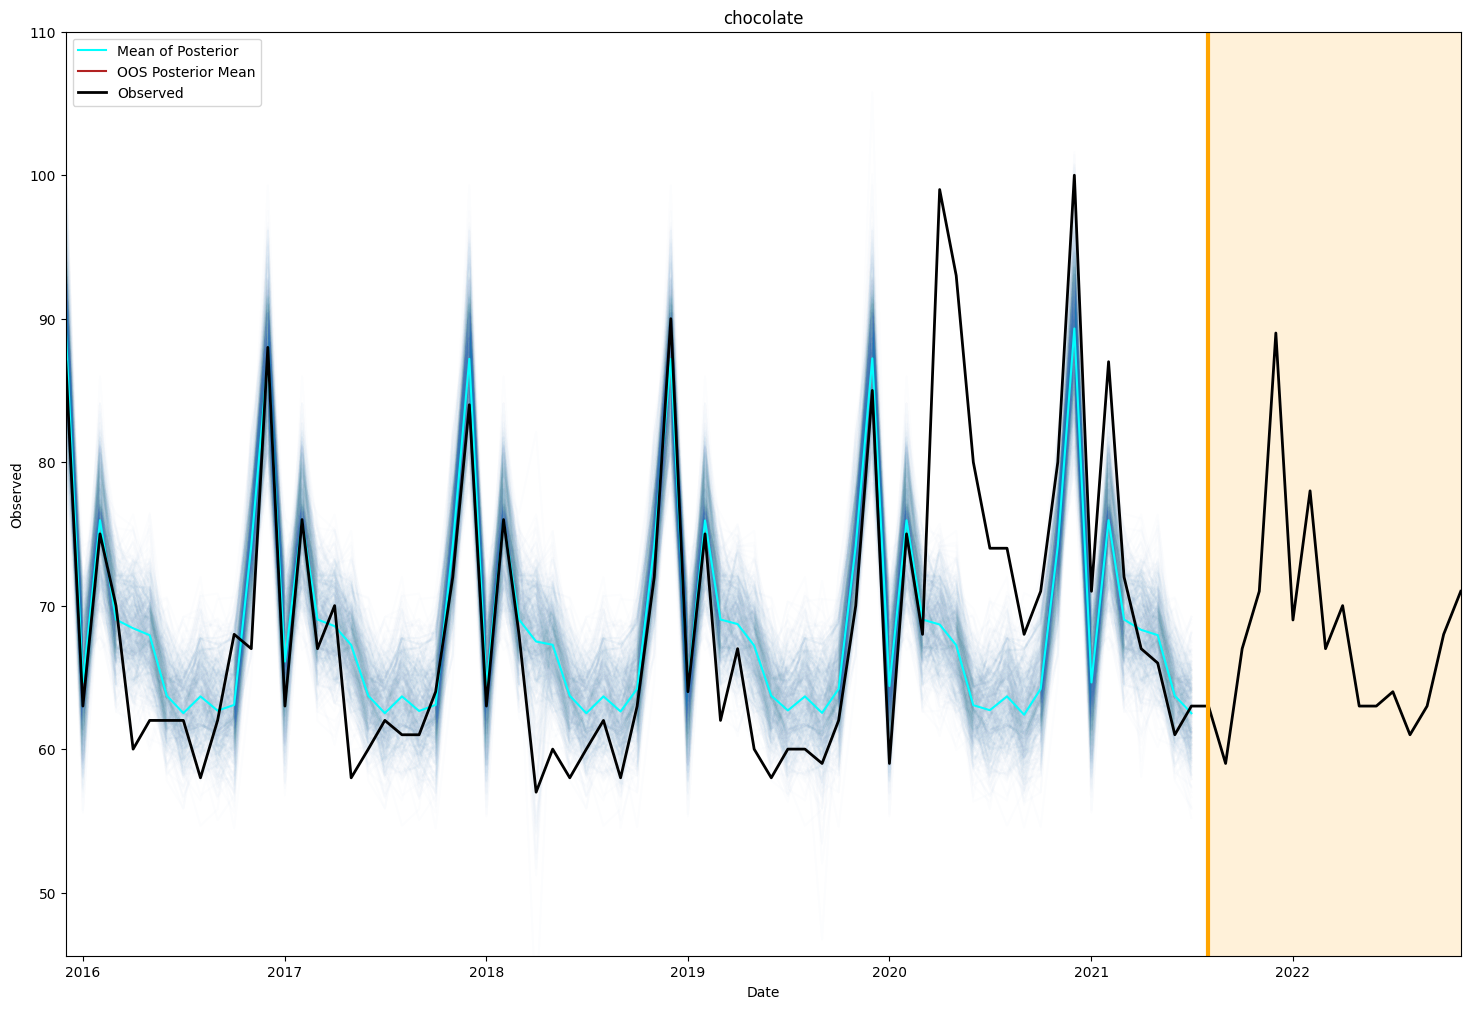

In [87]:
fig, ax = plt.subplots(figsize=(18, 12))
if plot_train:
    p = ax.plot(df_train.date, np.exp(log_mu[0, :]), alpha=0.01)
    clr = p[0].get_color()
    for i in range(1, alpha.shape[0]):
        ax.plot(df_train.date, np.exp(log_mu[i, :]), color=clr, alpha=0.01)
    ax.plot(
        df_train.date,
        np.exp(np.mean(log_mu, axis=0)),
        color="cyan",
        label="Mean of Posterior",
    )
if plot_test:
    p = ax.plot(df_test.date, np.exp(test_log_mu[0, :]), alpha=0.01)
    clr = p[0].get_color()
    for i in range(1, alpha.shape[0]):
        ax.plot(df_test.date, np.exp(test_log_mu[i, :]), color=clr, alpha=0.01)
    ax.plot(
        df_test.date,
        np.exp(np.mean(test_log_mu, axis=0)),
        color="firebrick",
        label="OOS Posterior Mean",
    )
if plot_train and plot_test:
    ax.plot(df.date, df.observed, label="Observed", lw=2, color="black")
    ax.set_xlim(pd.to_datetime(start_date), df.date.max())
elif plot_train:
    ax.plot(df_train.date, df_train.observed, label="Observed", lw=2, color="black")
    ax.set_xlim(pd.to_datetime(start_date), df_train.date.max())
elif plot_test:
    ax.plot(df_test.date, df_test.observed, label="Observed", lw=2, color="black")

ax.set_xlabel("Date")
ax.set_ylabel("Observed")

ax.legend(loc="upper left")

plt.axvspan(df_test.date.min(), df_test.date.max(), facecolor="orange", alpha=0.15)
plt.axvline(df_test.date.min(), color='orange', lw=3)
plt.title(name)
plt.ylim(0.8 * df.observed.min(), 1.1 * df.observed.max())
plt.xlim(pd.to_datetime(df.date.min()), df.date.max())

plt.show()